# May 5th, 2022 (global order or not? + sample vs. binary)

**Motivation**: in Group, find_best_mappings() is used to get the best permutations across seeds and runs.  Would it make sense to use global ordering or not?

**Findings**:
- use 'infer' and 'cosine'.
- 128 * 3: p25-binary is slightly better than p25-sample (but almost identical).
- 512 * 3: p25-sample is a clear winner, 100%.

**Conclusions**:
1. Use 'infer' and 'cosine'
2. Use f'p{p}-sample'

<br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from scipy.ndimage import gaussian_filter
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
def quick_show(tr1, tr2, vmin=0.1, vmax=None, figsize=(13.5, 4), cmap='magma'):
    num = max(len(tr1['proj-top']), len(tr2['proj-top']))
    fig, axes = create_figure(2, num, figsize)
    for i in range(num):

        ax = axes[0, i]
        if i >= len(tr1['proj-top']):
            ax.remove()
        else:
            ax.imshow(mwh(tr1['top'] == 0, tr1['top']), cmap='Greys_r')
            if np.nanmax(tr1['proj-top'][i]) > 1:
                _cmap = 'Accent_r'
                _vmax = None
            else:
                _cmap = cmap
                _vmax = vmax
            ax.imshow(mwh(tr1['proj-top'][i] < vmin, tr1['proj-top'][i]), cmap=_cmap, vmin=vmin, vmax=_vmax)

        ax = axes[1, i]
        if i >= len(tr2['proj-top']):
            ax.remove()
        else:
            ax.imshow(mwh(tr2['top'] == 0, tr2['top']), cmap='Greys_r')
            if np.nanmax(tr2['proj-top'][i]) > 1:
                _cmap = 'Accent_r'
                _vmax = None
            else:
                _cmap = cmap
                _vmax = vmax
            ax.imshow(mwh(tr2['proj-top'][i] < vmin, tr2['proj-top'][i]), cmap=_cmap, vmin=vmin, vmax=_vmax)

    remove_ticks(axes)
    plt.show()

## 128 * 3

In [3]:
mice = Mice((128, 3))
mice.setup_func_data('rest')

props_base = {
    'mice': mice,
    'perc': None,
    'num_k': None,
    'ordering': None,
    'dist_metric': None,
    'task': 'rest',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

In [4]:
p = 25
looper = itertools.product(
    [f'p{p}-binary', f'p{p}-sample'],
    [7, 11, 15],
    ['infer'],   # ['local', 'infer'],
    ['cosine'],  # ['cosine', 'correlation'],
)
results_ca, results_bo = [], []
for perc, num_k, ordering, metric in looper:
    _props = props_ca.copy()
    _props['perc'] = perc
    _props['num_k'] = num_k
    _props['ordering'] = ordering
    _props['dist_metric'] = metric
    gr_ca = Group(**_props).fit_group()
    _props = props_bo.copy()
    _props['perc'] = perc
    _props['num_k'] = num_k
    _props['ordering'] = ordering
    _props['dist_metric'] = metric
    gr_bo = Group(**_props).fit_group()

    gr_ca.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_ca.run_pi, 3), 2), 1), 0)
    gr_bo.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_bo.run_pi, 3), 2), 1), 0)
    results_ca.append(gr_ca)
    results_bo.append(gr_bo)

K7, perc: p25-binary,  task: rest,  (infer-cosine)

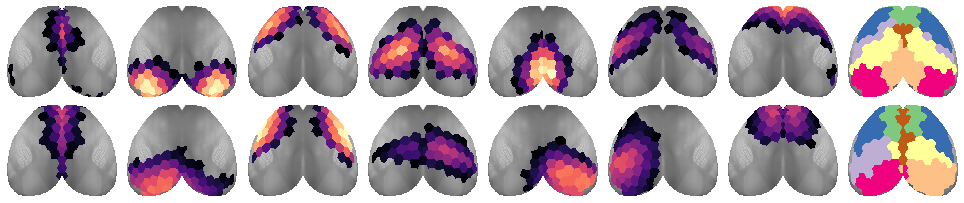

K11, perc: p25-binary,  task: rest,  (infer-cosine)

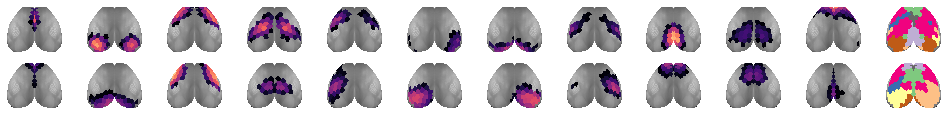

K15, perc: p25-binary,  task: rest,  (infer-cosine)

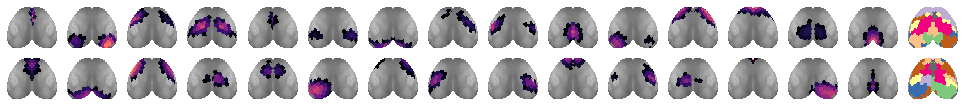

K7, perc: p25-sample,  task: rest,  (infer-cosine)

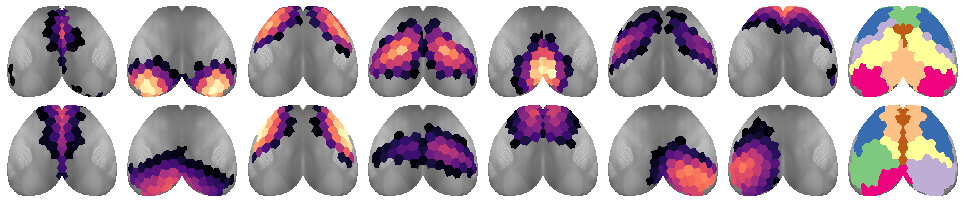

K11, perc: p25-sample,  task: rest,  (infer-cosine)

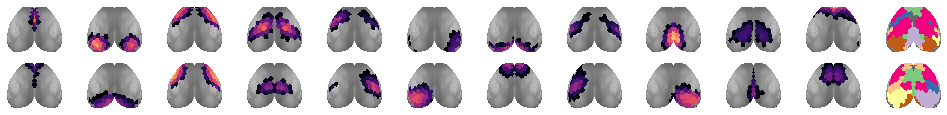

K15, perc: p25-sample,  task: rest,  (infer-cosine)

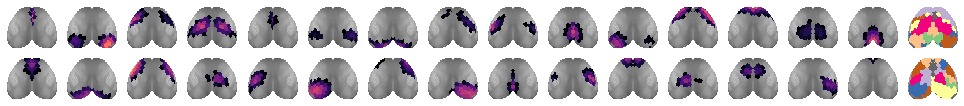

In [5]:
for gr_ca, gr_bo in zip(results_ca, results_bo):
    assert all(
        getattr(gr_ca, attr) == getattr(gr_bo, attr) for attr
        in ['perc', 'num_k', 'ordering', 'dist_metric']
    )
    tr_ca = gr_ca.project_vec()
    tr_ca = gr_ca.trim2d(tr_ca)
    tr_bo = gr_bo.project_vec()
    tr_bo = gr_bo.trim2d(tr_bo)
    
    print(f"K{gr_ca.num_k}, perc: {gr_ca.perc},  task: {gr_ca.task},  ({gr_ca.ordering}-{gr_ca.dist_metric})")
    if gr_ca.num_k == 7:
        figsize = (13.5, 3)
    elif gr_ca.num_k == 1:
        figsize = (13.5, 2.3)
    else:
        figsize = (13.5, 1.7)
    quick_show(tr_ca, tr_bo, 0.13, 0.7, figsize)
    print('\n\n')

In [6]:
vmin_ent, vmax_ent = [], []
entropy = {}
dlist = []
for gr_ca, gr_bo in zip(results_ca, results_bo):
    assert all(
        getattr(gr_ca, attr) == getattr(gr_bo, attr) for attr
        in ['perc', 'num_k', 'ordering', 'dist_metric']
    )
    h = np.concatenate([
        sp_stats.entropy(gr_ca.pi, axis=-2).reshape(1, -1),
        sp_stats.entropy(gr_bo.pi, axis=-2).reshape(1, -1),
    ]) / np.log(num_k)
    vmin_ent.append(np.nanmin(h[h.nonzero()]))
    vmax_ent.append(np.nanmax(h[h.nonzero()]))

    tr = gr_ca.project_vec(h, add_disjoint=False)
    lbl = (gr_ca.num_k, gr_ca.perc, gr_ca.ordering, gr_ca.dist_metric)
    entropy[lbl] = gr_ca.trim2d(tr)

    # h sym score
    h_sym = gr_ca.pi_symmetry_score(h, decimals=10)[0]
    dlist.append({
        'perc': [gr_ca.perc] * 2,
        'num_k': [gr_ca.num_k] * 2,
        'ordering': [gr_ca.ordering] * 2,
        'metric': [gr_ca.dist_metric] * 2,
        'mode': ['ca2', 'bold'],
        'label': ['h_sym'] * 2,
        'oc_idx': [-100] * 2,
        'score': [h_sym[1], h_sym[2]],
    })

    # pi sym score: CA2
    ovp, disj = gr_ca.pi_symmetry_score(decimals=10)
    dlist.append({
        'perc': [gr_ca.perc] * len(ovp),
        'num_k': [gr_ca.num_k] * len(ovp),
        'ordering': [gr_ca.ordering] * len(ovp),
        'metric': [gr_ca.dist_metric] * len(ovp),
        'mode': ['ca2'] * len(ovp),
        'label': ['ovp'] * len(ovp),
        'oc_idx': ovp.keys(),
        'score': ovp.values(),
    })
    dlist.append({
        'perc': [gr_ca.perc] * len(disj),
        'num_k': [gr_ca.num_k] * len(disj),
        'ordering': [gr_ca.ordering] * len(disj),
        'metric': [gr_ca.dist_metric] * len(disj),
        'mode': ['ca2'] * len(disj),
        'label': ['disj'] * len(disj),
        'oc_idx': disj.keys(),
        'score': disj.values(),
    })

    # pi sym score: BOLD
    ovp, disj = gr_bo.pi_symmetry_score(decimals=10)
    dlist.append({
        'perc': [gr_ca.perc] * len(ovp),
        'num_k': [gr_ca.num_k] * len(ovp),
        'ordering': [gr_ca.ordering] * len(ovp),
        'metric': [gr_ca.dist_metric] * len(ovp),
        'mode': ['bold'] * len(ovp),
        'label': ['ovp'] * len(ovp),
        'oc_idx': ovp.keys(),
        'score': ovp.values(),
    })
    dlist.append({
        'perc': [gr_ca.perc] * len(disj),
        'num_k': [gr_ca.num_k] * len(disj),
        'ordering': [gr_ca.ordering] * len(disj),
        'metric': [gr_ca.dist_metric] * len(disj),
        'mode': ['bold'] * len(disj),
        'label': ['disj'] * len(disj),
        'oc_idx': disj.keys(),
        'score': disj.values(),
    })
        
df = pd.DataFrame(merge_dicts(dlist))

In [8]:
df['metric'].unique()

array(['cosine'], dtype=object)

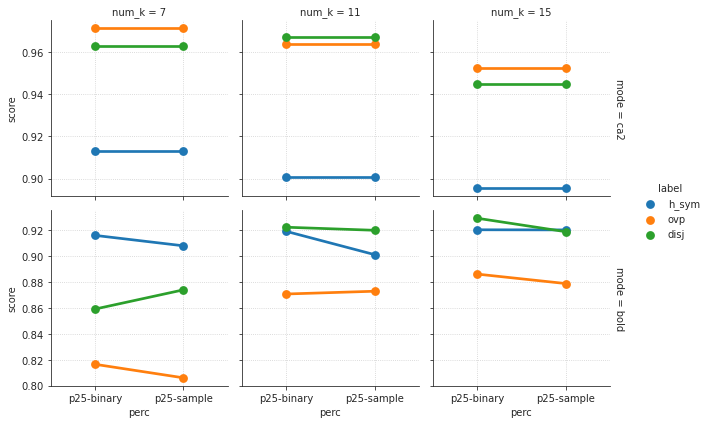

In [9]:
_df = df.loc[
    (df['oc_idx'].isin([-1, -100]))
]
fg = sns.catplot(
    data=_df,
    kind='point',
    x='perc',
    col='num_k',
    row='mode',
    y='score',
    hue='label',
    sharey='row',
    margin_titles=True,
    height=3,
)
_ = add_grid(fg.axes)
plt.show()

In [21]:
kws = {
    'cmap': 'nipy_spectral',
    'vmin': np.array(vmin_ent).min(),
    'vmax': np.array(vmax_ent).max(),
}
kws

{
    'cmap': 'nipy_spectral',
    'vmin': 0.35943077847162236,
    'vmax': 0.9083698583527215
}

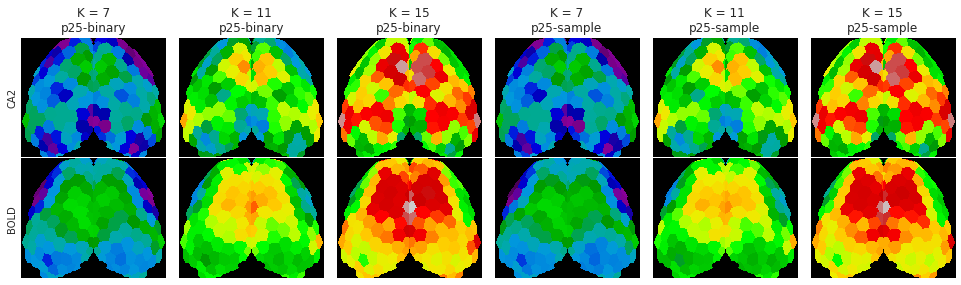

In [22]:
fig, axes = create_figure(2, len(entropy), (13.5, 4.))
for i, (lbl, tr) in enumerate(entropy.items()):
    num_k, perc, ordering, dist_metric = lbl
    axes[0, i].set_title(f"K = {num_k}\n{perc}")
    for j in range(2):
        ax = axes[j, i]
        ax.imshow(tr['proj-top'][j], **kws)
axes[0, 0].set_ylabel('CA2')
axes[1, 0].set_ylabel('BOLD')
# fig.suptitle('K = 7', fontsize=14)
remove_ticks(axes)

### This was to discover infer vs local, corr vs cos etc

7 p25-binary local cosine

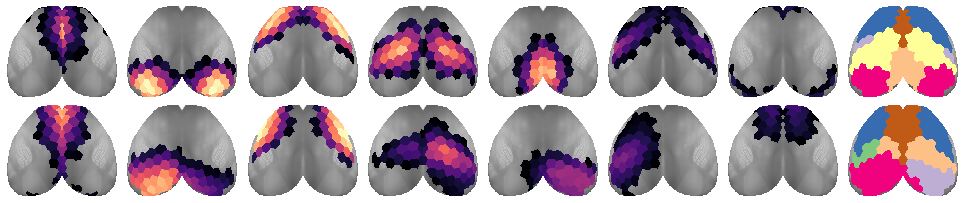

7 p25-binary local correlation

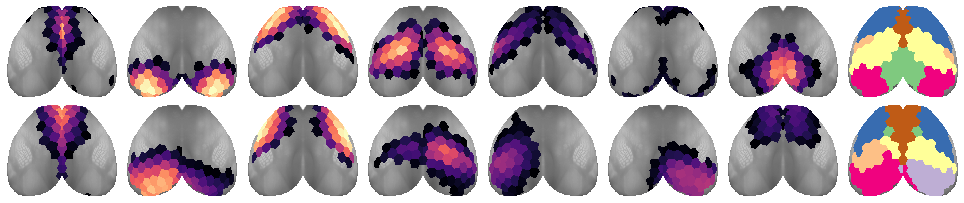

7 p25-binary infer cosine

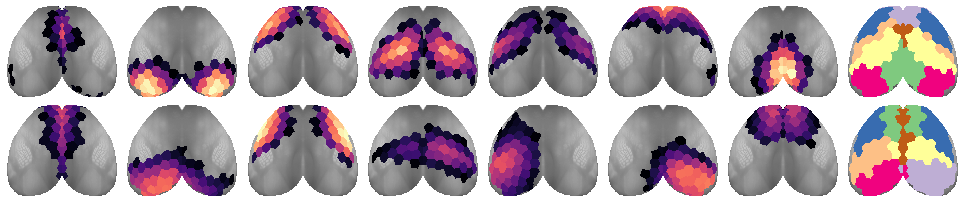

7 p25-binary infer correlation

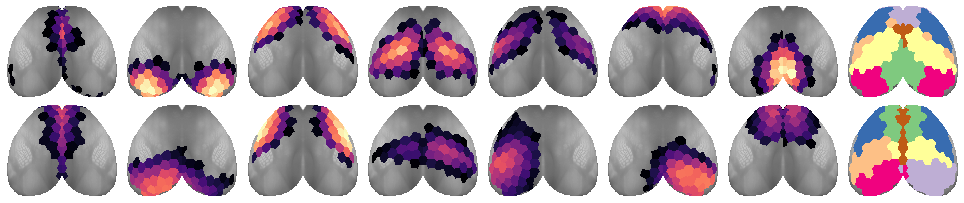

11 p25-binary local cosine

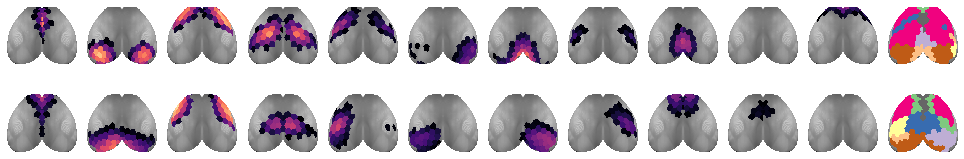

11 p25-binary local correlation

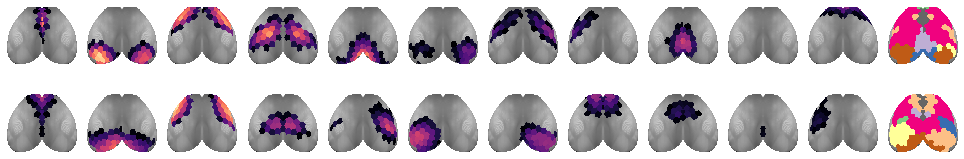

11 p25-binary infer cosine

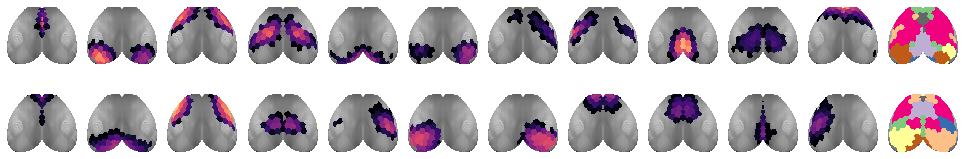

11 p25-binary infer correlation

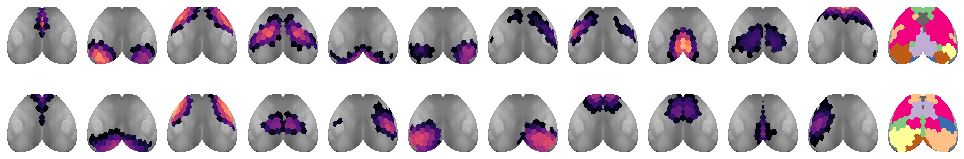

7 p25-sample local cosine

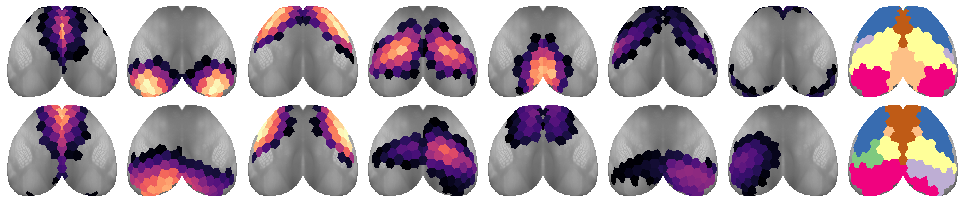

7 p25-sample local correlation

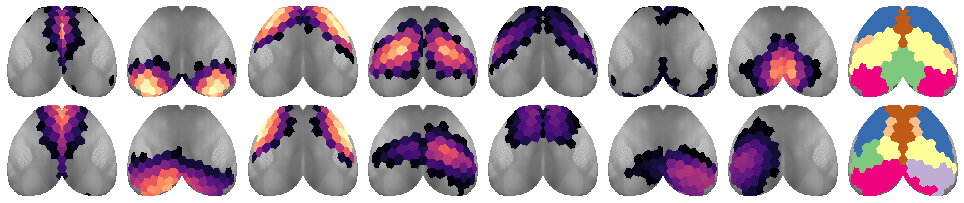

7 p25-sample infer cosine

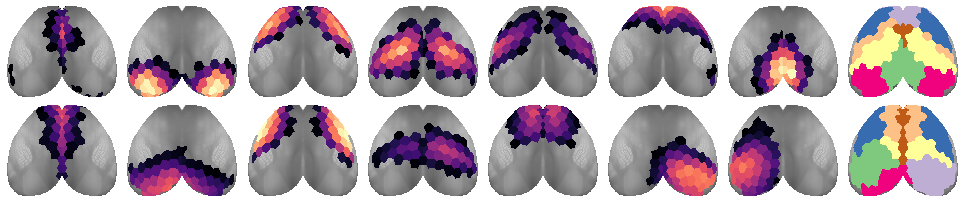

7 p25-sample infer correlation

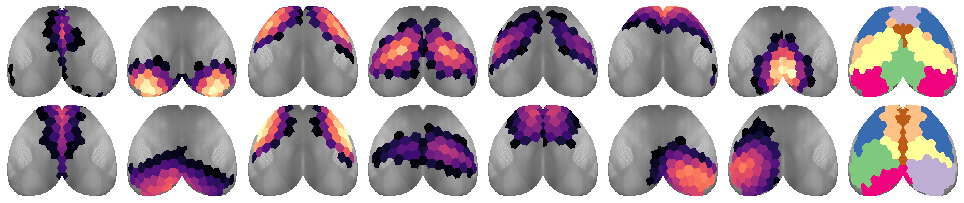

11 p25-sample local cosine

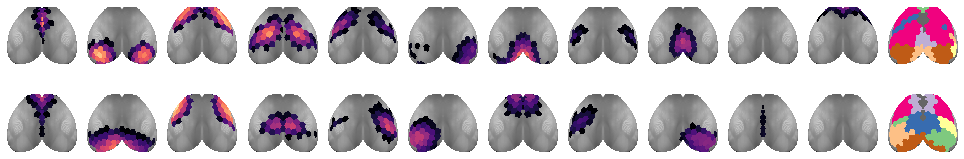

11 p25-sample local correlation

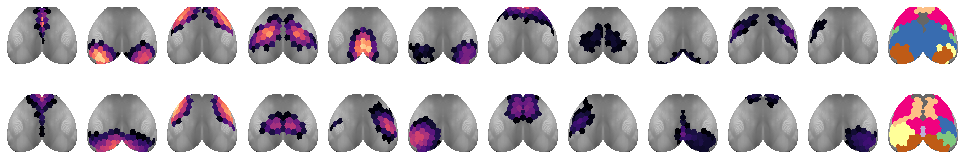

11 p25-sample infer cosine

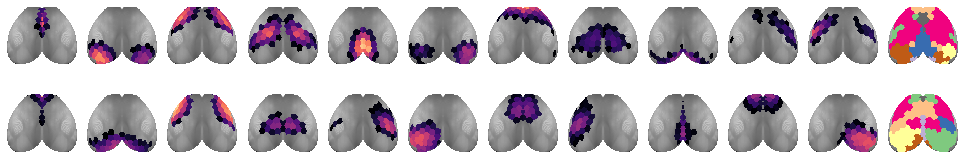

11 p25-sample infer correlation

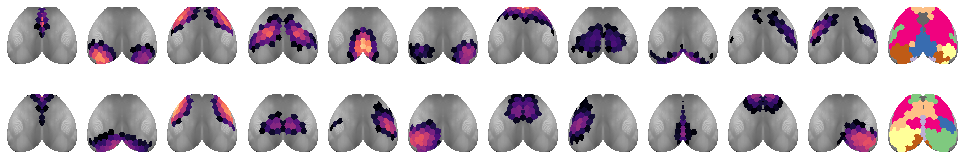

In [30]:
vmin_ent, vmax_ent = [], []
entropy = {}
dlist = []
for gr_ca, gr_bo in zip(results_ca, results_bo):
    assert all(
        getattr(gr_ca, attr) == getattr(gr_bo, attr) for attr
        in ['perc', 'num_k', 'ordering', 'dist_metric']
    )
    h = np.concatenate([
        sp_stats.entropy(gr_ca.pi, axis=-2).reshape(1, -1),
        sp_stats.entropy(gr_bo.pi, axis=-2).reshape(1, -1),
    ]) / np.log(num_k)
    vmin_ent.append(np.nanmin(h[h.nonzero()]))
    vmax_ent.append(np.nanmax(h[h.nonzero()]))

    tr = gr_ca.project_vec(h, add_disjoint=False)
    lbl = (gr_ca.num_k, gr_ca.perc, gr_ca.ordering, gr_ca.dist_metric)
    entropy[lbl] = gr_ca.trim2d(tr)

    # h sym score
    h_sym = gr_ca.pi_symmetry_score(h, decimals=10)[0]
    dlist.append({
        'perc': [gr_ca.perc] * 2,
        'num_k': [gr_ca.num_k] * 2,
        'ordering': [gr_ca.ordering] * 2,
        'metric': [gr_ca.dist_metric] * 2,
        'mode': ['ca2', 'bold'],
        'label': ['h_sym'] * 2,
        'oc_idx': [-100] * 2,
        'score': [h_sym[1], h_sym[2]],
    })

    # pi sym score: CA2
    ovp, disj = gr_ca.pi_symmetry_score(decimals=10)
    dlist.append({
        'perc': [gr_ca.perc] * len(ovp),
        'num_k': [gr_ca.num_k] * len(ovp),
        'ordering': [gr_ca.ordering] * len(ovp),
        'metric': [gr_ca.dist_metric] * len(ovp),
        'mode': ['ca2'] * len(ovp),
        'label': ['ovp'] * len(ovp),
        'oc_idx': ovp.keys(),
        'score': ovp.values(),
    })
    dlist.append({
        'perc': [gr_ca.perc] * len(disj),
        'num_k': [gr_ca.num_k] * len(disj),
        'ordering': [gr_ca.ordering] * len(disj),
        'metric': [gr_ca.dist_metric] * len(disj),
        'mode': ['ca2'] * len(disj),
        'label': ['disj'] * len(disj),
        'oc_idx': disj.keys(),
        'score': disj.values(),
    })

    # pi sym score: BOLD
    ovp, disj = gr_bo.pi_symmetry_score(decimals=10)
    dlist.append({
        'perc': [gr_ca.perc] * len(ovp),
        'num_k': [gr_ca.num_k] * len(ovp),
        'ordering': [gr_ca.ordering] * len(ovp),
        'metric': [gr_ca.dist_metric] * len(ovp),
        'mode': ['bold'] * len(ovp),
        'label': ['ovp'] * len(ovp),
        'oc_idx': ovp.keys(),
        'score': ovp.values(),
    })
    dlist.append({
        'perc': [gr_ca.perc] * len(disj),
        'num_k': [gr_ca.num_k] * len(disj),
        'ordering': [gr_ca.ordering] * len(disj),
        'metric': [gr_ca.dist_metric] * len(disj),
        'mode': ['bold'] * len(disj),
        'label': ['disj'] * len(disj),
        'oc_idx': disj.keys(),
        'score': disj.values(),
    })
        
df = pd.DataFrame(merge_dicts(dlist))

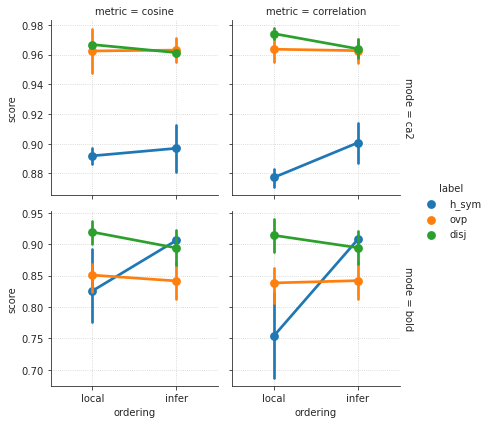

In [31]:
_df = df.loc[df['oc_idx'].isin([-1, -100])]

fg = sns.catplot(
    data=_df,
    kind='point',
    x='ordering',
    col='metric',
    row='mode',
    y='score',
    hue='label',
    sharey='row',
    margin_titles=True,
    height=3,
)
_ = add_grid(fg.axes)
plt.show()

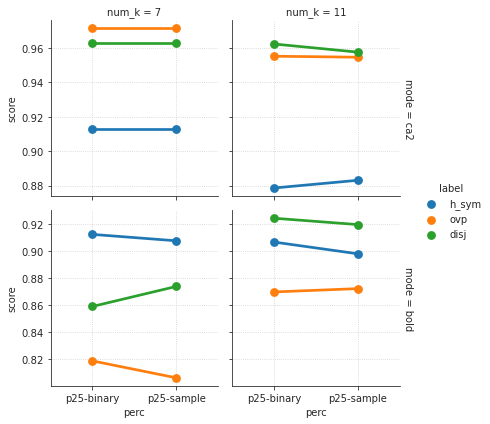

In [33]:
_df = df.loc[
    (df['metric'] == 'cosine') &
    (df['ordering'] == 'infer') &
    (df['oc_idx'].isin([-1, -100]))
]
fg = sns.catplot(
    data=_df,
    kind='point',
    x='perc',
    col='num_k',
    row='mode',
    y='score',
    hue='label',
    sharey='row',
    margin_titles=True,
    height=3,
)
_ = add_grid(fg.axes)
plt.show()

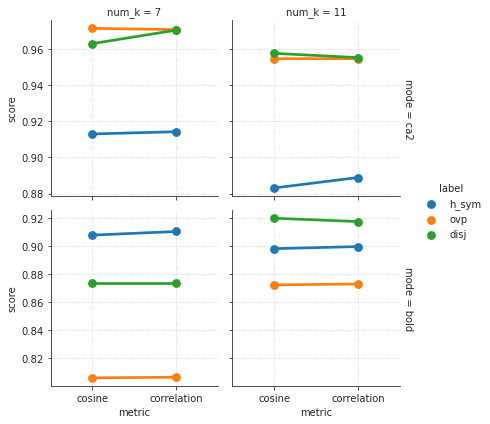

In [39]:
_df = df.loc[
    (df['ordering'] == 'infer') &
    (df['perc'] == 'p25-sample') &
    (df['oc_idx'].isin([-1, -100]))
]
fg = sns.catplot(
    data=_df,
    kind='point',
    x='metric',
    y='score',
    col='num_k',
    row='mode',
    hue='label',
    sharey='row',
    margin_titles=True,
    height=3,
)
_ = add_grid(fg.axes)
plt.show()

In [68]:
selected_data = {lbl: x for lbl, x in entropy.items() if lbl[0] == 7}
selected_ids = [i for i, (lbl, x) in enumerate(entropy.items()) if lbl[0] == 7]
kws = {
    'cmap': 'nipy_spectral',
    'vmin': np.array(vmin_ent)[selected_ids].min(),
    'vmax': np.array(vmax_ent)[selected_ids].max(),
}

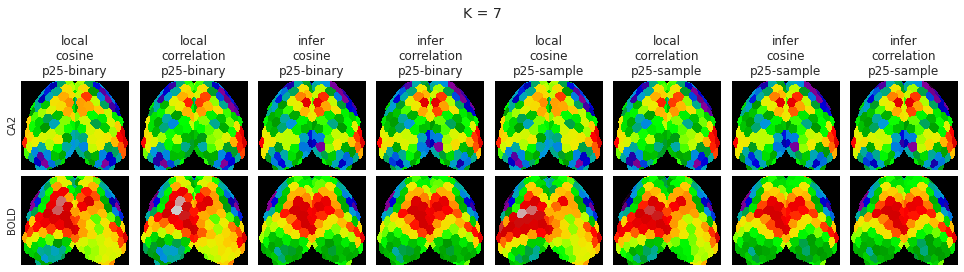

In [69]:
fig, axes = create_figure(2, len(selected_data), (13.5, 4.))
for i, (lbl, tr) in enumerate(selected_data.items()):
    num_k, perc, ordering, dist_metric = lbl
    axes[0, i].set_title(f"{ordering}\n{dist_metric}\n{perc}")
    for j in range(2):
        ax = axes[j, i]
        ax.imshow(tr['proj-top'][j], **kws)
axes[0, 0].set_ylabel('CA2')
axes[1, 0].set_ylabel('BOLD')
fig.suptitle('K = 7', fontsize=14)
remove_ticks(axes)

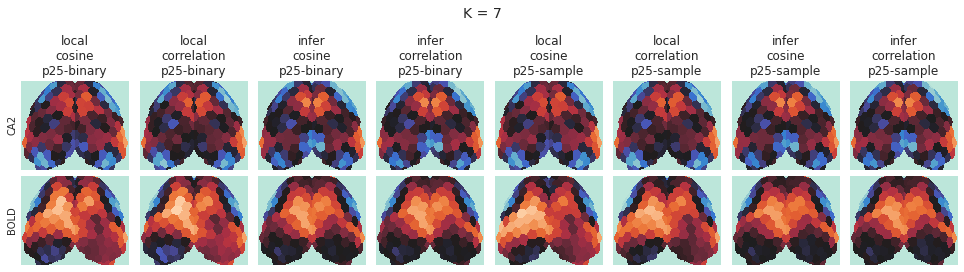

In [70]:
kws['cmap'] = 'icefire'
fig, axes = create_figure(2, len(selected_data), (13.5, 4.))
for i, (lbl, tr) in enumerate(selected_data.items()):
    num_k, perc, ordering, dist_metric = lbl
    axes[0, i].set_title(f"{ordering}\n{dist_metric}\n{perc}")
    for j in range(2):
        ax = axes[j, i]
        ax.imshow(tr['proj-top'][j], **kws)
axes[0, 0].set_ylabel('CA2')
axes[1, 0].set_ylabel('BOLD')
fig.suptitle('K = 7', fontsize=14)
remove_ticks(axes)

In [71]:
selected_data = {lbl: x for lbl, x in entropy.items() if lbl[0] == 11}
selected_ids = [i for i, (lbl, x) in enumerate(entropy.items()) if lbl[0] == 11]
kws = {
    'cmap': 'nipy_spectral',
    'vmin': np.array(vmin_ent)[selected_ids].min(),
    'vmax': np.array(vmax_ent)[selected_ids].max(),
}

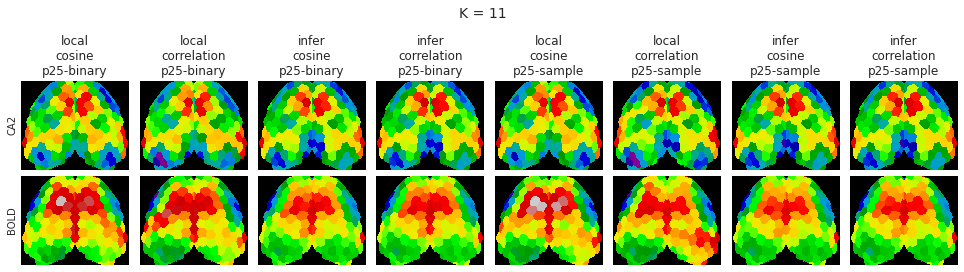

In [72]:
fig, axes = create_figure(2, len(selected_data), (13.5, 4.))
for i, (lbl, tr) in enumerate(selected_data.items()):
    num_k, perc, ordering, dist_metric = lbl
    axes[0, i].set_title(f"{ordering}\n{dist_metric}\n{perc}")
    for j in range(2):
        ax = axes[j, i]
        ax.imshow(tr['proj-top'][j], **kws)
axes[0, 0].set_ylabel('CA2')
axes[1, 0].set_ylabel('BOLD')
fig.suptitle('K = 11', fontsize=14)
remove_ticks(axes)

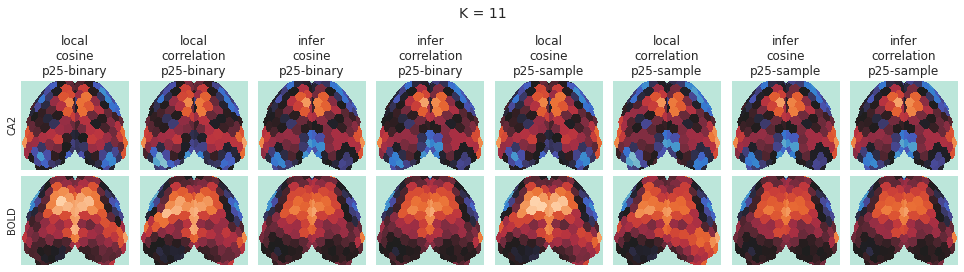

In [73]:
kws['cmap'] = 'icefire'
fig, axes = create_figure(2, len(selected_data), (13.5, 4.))
for i, (lbl, tr) in enumerate(selected_data.items()):
    num_k, perc, ordering, dist_metric = lbl
    axes[0, i].set_title(f"{ordering}\n{dist_metric}\n{perc}")
    for j in range(2):
        ax = axes[j, i]
        ax.imshow(tr['proj-top'][j], **kws)
axes[0, 0].set_ylabel('CA2')
axes[1, 0].set_ylabel('BOLD')
fig.suptitle('K = 11', fontsize=14)
remove_ticks(axes)

## 512 * 3

In [3]:
mice = Mice((512, 3))
mice.setup_func_data('rest')

props_base = {
    'mice': mice,
    'perc': None,
    'num_k': None,
    'ordering': None,
    'dist_metric': None,
    'task': 'rest',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

In [4]:
p = 25
looper = itertools.product(
    [f'p{p}-binary', f'p{p}-sample'],
    [7, 11, 15],
    ['infer'],   # ['local', 'infer'],
    ['cosine'],  # ['cosine', 'correlation'],
)
results_ca, results_bo = [], []
for perc, num_k, ordering, metric in looper:
    _props = props_ca.copy()
    _props['perc'] = perc
    _props['num_k'] = num_k
    _props['ordering'] = ordering
    _props['dist_metric'] = metric
    gr_ca = Group(**_props).fit_group()
    _props = props_bo.copy()
    _props['perc'] = perc
    _props['num_k'] = num_k
    _props['ordering'] = ordering
    _props['dist_metric'] = metric
    gr_bo = Group(**_props).fit_group()

    gr_ca.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_ca.run_pi, 3), 2), 1), 0)
    gr_bo.pi = bn.nanmean(bn.nanmean(bn.nanmean(bn.nanmean(gr_bo.run_pi, 3), 2), 1), 0)
    results_ca.append(gr_ca)
    results_bo.append(gr_bo)

K7, perc: p25-binary,  task: rest,  (infer-cosine)

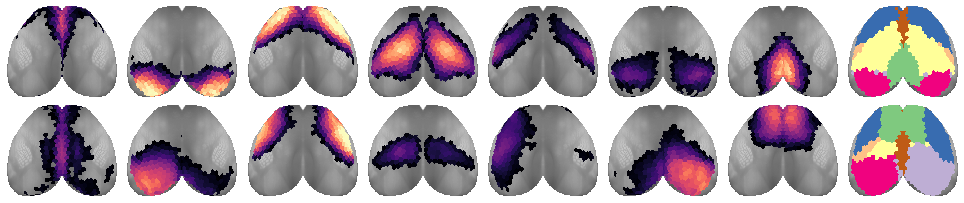

K11, perc: p25-binary,  task: rest,  (infer-cosine)

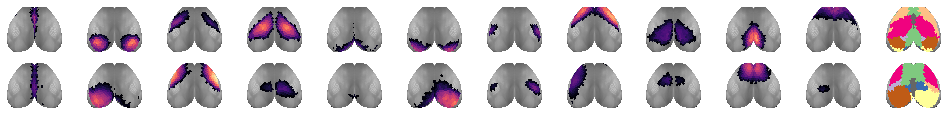

K15, perc: p25-binary,  task: rest,  (infer-cosine)

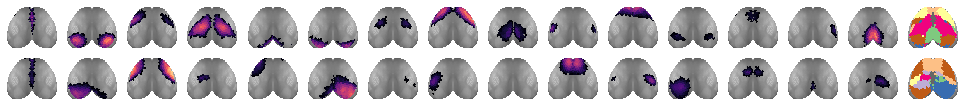

K7, perc: p25-sample,  task: rest,  (infer-cosine)

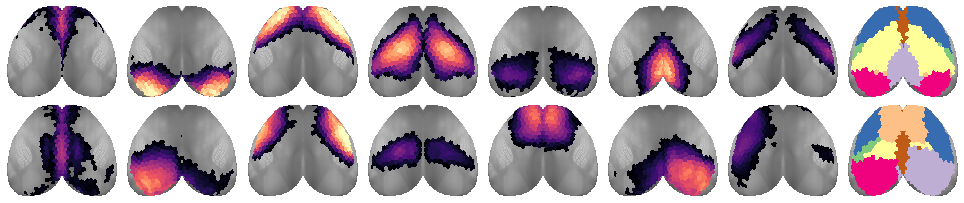

K11, perc: p25-sample,  task: rest,  (infer-cosine)

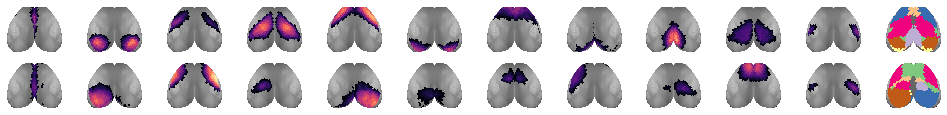

K15, perc: p25-sample,  task: rest,  (infer-cosine)

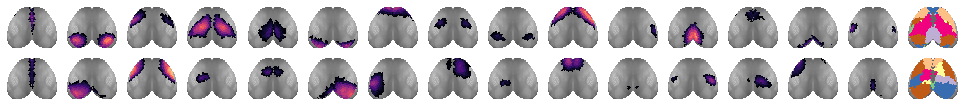

In [5]:
for gr_ca, gr_bo in zip(results_ca, results_bo):
    assert all(
        getattr(gr_ca, attr) == getattr(gr_bo, attr) for attr
        in ['perc', 'num_k', 'ordering', 'dist_metric']
    )
    tr_ca = gr_ca.project_vec()
    tr_ca = gr_ca.trim2d(tr_ca)
    tr_bo = gr_bo.project_vec()
    tr_bo = gr_bo.trim2d(tr_bo)
    
    print(f"K{gr_ca.num_k}, perc: {gr_ca.perc},  task: {gr_ca.task},  ({gr_ca.ordering}-{gr_ca.dist_metric})")
    if gr_ca.num_k == 7:
        figsize = (13.5, 3)
    elif gr_ca.num_k == 1:
        figsize = (13.5, 2.3)
    else:
        figsize = (13.5, 1.7)
    quick_show(tr_ca, tr_bo, 0.13, 0.7, figsize)
    print('\n\n')

In [6]:
vmin_ent, vmax_ent = [], []
entropy = {}
dlist = []
for gr_ca, gr_bo in zip(results_ca, results_bo):
    assert all(
        getattr(gr_ca, attr) == getattr(gr_bo, attr) for attr
        in ['perc', 'num_k', 'ordering', 'dist_metric']
    )
    h = np.concatenate([
        sp_stats.entropy(gr_ca.pi, axis=-2).reshape(1, -1),
        sp_stats.entropy(gr_bo.pi, axis=-2).reshape(1, -1),
    ]) / np.log(num_k)
    vmin_ent.append(np.nanmin(h[h.nonzero()]))
    vmax_ent.append(np.nanmax(h[h.nonzero()]))

    tr = gr_ca.project_vec(h, add_disjoint=False)
    lbl = (gr_ca.num_k, gr_ca.perc, gr_ca.ordering, gr_ca.dist_metric)
    entropy[lbl] = gr_ca.trim2d(tr)

    # h sym score
    h_sym = gr_ca.pi_symmetry_score(h, decimals=10)[0]
    dlist.append({
        'perc': [gr_ca.perc] * 2,
        'num_k': [gr_ca.num_k] * 2,
        'ordering': [gr_ca.ordering] * 2,
        'metric': [gr_ca.dist_metric] * 2,
        'mode': ['ca2', 'bold'],
        'label': ['h_sym'] * 2,
        'oc_idx': [-100] * 2,
        'score': [h_sym[1], h_sym[2]],
    })

    # pi sym score: CA2
    ovp, disj = gr_ca.pi_symmetry_score(decimals=10)
    dlist.append({
        'perc': [gr_ca.perc] * len(ovp),
        'num_k': [gr_ca.num_k] * len(ovp),
        'ordering': [gr_ca.ordering] * len(ovp),
        'metric': [gr_ca.dist_metric] * len(ovp),
        'mode': ['ca2'] * len(ovp),
        'label': ['ovp'] * len(ovp),
        'oc_idx': ovp.keys(),
        'score': ovp.values(),
    })
    dlist.append({
        'perc': [gr_ca.perc] * len(disj),
        'num_k': [gr_ca.num_k] * len(disj),
        'ordering': [gr_ca.ordering] * len(disj),
        'metric': [gr_ca.dist_metric] * len(disj),
        'mode': ['ca2'] * len(disj),
        'label': ['disj'] * len(disj),
        'oc_idx': disj.keys(),
        'score': disj.values(),
    })

    # pi sym score: BOLD
    ovp, disj = gr_bo.pi_symmetry_score(decimals=10)
    dlist.append({
        'perc': [gr_ca.perc] * len(ovp),
        'num_k': [gr_ca.num_k] * len(ovp),
        'ordering': [gr_ca.ordering] * len(ovp),
        'metric': [gr_ca.dist_metric] * len(ovp),
        'mode': ['bold'] * len(ovp),
        'label': ['ovp'] * len(ovp),
        'oc_idx': ovp.keys(),
        'score': ovp.values(),
    })
    dlist.append({
        'perc': [gr_ca.perc] * len(disj),
        'num_k': [gr_ca.num_k] * len(disj),
        'ordering': [gr_ca.ordering] * len(disj),
        'metric': [gr_ca.dist_metric] * len(disj),
        'mode': ['bold'] * len(disj),
        'label': ['disj'] * len(disj),
        'oc_idx': disj.keys(),
        'score': disj.values(),
    })
        
df = pd.DataFrame(merge_dicts(dlist))

In [7]:
df['metric'].unique()

array(['cosine'], dtype=object)

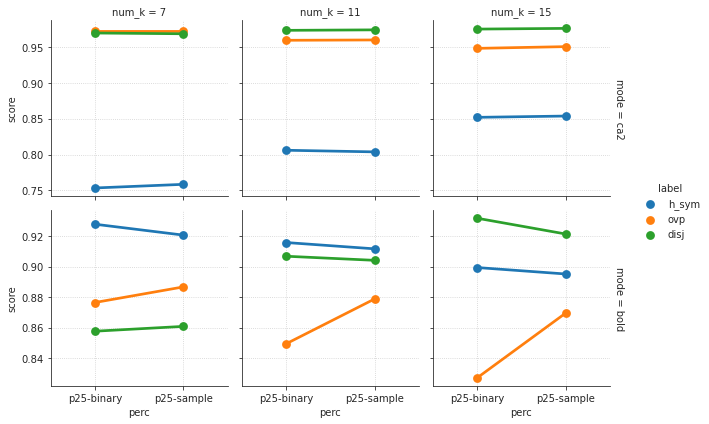

In [8]:
_df = df.loc[
    (df['oc_idx'].isin([-1, -100]))
]
fg = sns.catplot(
    data=_df,
    kind='point',
    x='perc',
    col='num_k',
    row='mode',
    y='score',
    hue='label',
    sharey='row',
    margin_titles=True,
    height=3,
)
_ = add_grid(fg.axes)
plt.show()

In [9]:
kws = {
    'cmap': 'nipy_spectral',
    'vmin': np.array(vmin_ent).min(),
    'vmax': np.array(vmax_ent).max(),
}
kws

{
    'cmap': 'nipy_spectral',
    'vmin': 0.27765151153239054,
    'vmax': 0.9479583602729758
}

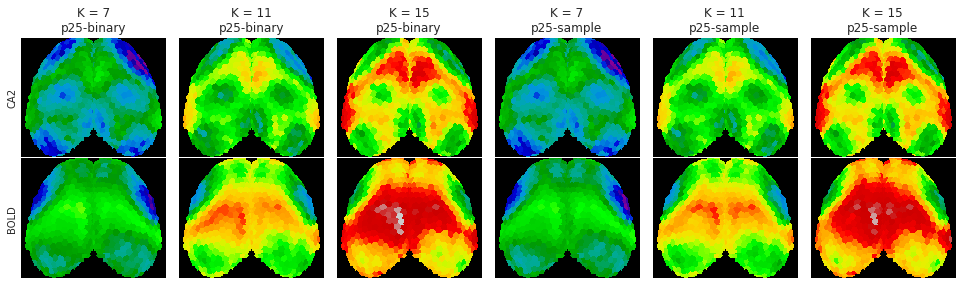

In [10]:
fig, axes = create_figure(2, len(entropy), (13.5, 4.))
for i, (lbl, tr) in enumerate(entropy.items()):
    num_k, perc, ordering, dist_metric = lbl
    axes[0, i].set_title(f"K = {num_k}\n{perc}")
    for j in range(2):
        ax = axes[j, i]
        ax.imshow(tr['proj-top'][j], **kws)
axes[0, 0].set_ylabel('CA2')
axes[1, 0].set_ylabel('BOLD')
# fig.suptitle('K = 7', fontsize=14)
remove_ticks(axes)